2017-01-11 19:16:48 

# Imports

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [48]:
import loompy
from imp import reload
import sys
import shutil
import glob
import datetime
import pandas as pd
sys.path.append('/home/gioele/Github/cytograph/differentiation_topology/')
import QC
import xlsxwriter

In [72]:
"python 3.5", loompy.__version__, numpy.__version__

('python 3.5', '0.22.14', '1.11.2')

In [3]:
loompy = reload(loompy)

## Functions definition

In [4]:
def loompy2data(filename):
    ds = loompy.connect(filename)
    return pd.DataFrame(data=ds[:,:], columns=ds.col_attrs['CellID'], index=ds.row_attrs['Gene']).astype(int)

def loompy2annot(filename):
    ds = loompy.connect(filename)
    return pd.DataFrame( ds.col_attrs, index=ds.col_attrs['CellID'] ).T

def loompy2data_annot(filename):
    ds = loompy.connect(filename)
    return (pd.DataFrame(data=ds[:,:],
                        columns=ds.col_attrs['CellID'],
                        index=ds.row_attrs['Gene']).astype(int),
            pd.DataFrame( ds.col_attrs,
                         index=ds.col_attrs['CellID'] ).T )

# Check for failed samples

## Extract some basic statistics from the num files in PARALLEL

In [10]:
paths_to_check = glob.glob( "/data2/loom_files/development/*.loom")

In [11]:
import multiprocessing
import ctypes
import numpy as np

#Shared memory object (a numpy array wrapped c array)
n,m = (5, len(paths_to_check))
shared_array_base = multiprocessing.Array(ctypes.c_double, n*m)
shared_array = np.ctypeslib.as_array(shared_array_base.get_obj())
shared_array = shared_array.reshape(n, m)

# Write multiprocessing ready function
def stats_loom_file(i,filename, def_par=shared_array):
    ds = loompy.connect(filename)
    M = ds[:]
    total_molecules = M.sum(0)
    mean_total_mol = total_molecules.mean()
    p90_total_mol = np.percentile(total_molecules, 90)
    N_pass_filter = np.sum( total_molecules > 1600)
    N_genes_expressed_mean = np.mean( (M>0).sum(0) )
    n_cells = ds.shape[1]
    def_par[0,i] = mean_total_mol
    def_par[1,i] = p90_total_mol
    def_par[2,i] = N_pass_filter
    def_par[3,i] = N_genes_expressed_mean
    def_par[4,i] = n_cells
    
# Parallel processing
pool = multiprocessing.Pool(processes=18)
try:
    for i, filename in enumerate(paths_to_check):
        pool.apply_async(stats_loom_file,(i,filename))
    pool.close()
    pool.join()
except KeyboardInterrupt:
    pool.terminate()

2017-01-12 01:50:05,442 - INFO - Connecting to: /data2/loom_files/development/10X23_4.loom
2017-01-12 01:50:05,442 - INFO - Connecting to: /data2/loom_files/development/10X23_3.loom
2017-01-12 01:50:05,445 - INFO - Connecting to: /data2/loom_files/development/10X31_5.loom
2017-01-12 01:50:05,447 - INFO - Connecting to: /data2/loom_files/development/10X32_6.loom
2017-01-12 01:50:05,446 - INFO - Connecting to: /data2/loom_files/development/10X32_3.loom
2017-01-12 01:50:05,445 - INFO - Connecting to: /data2/loom_files/development/10X32_2.loom
2017-01-12 01:50:05,446 - INFO - Connecting to: /data2/loom_files/development/10X32_4.loom
2017-01-12 01:50:05,446 - INFO - Connecting to: /data2/loom_files/development/10X10_2.loom
2017-01-12 01:50:05,445 - INFO - Connecting to: /data2/loom_files/development/10X27_7.loom
2017-01-12 01:50:05,446 - INFO - Connecting to: /data2/loom_files/development/10X10_3.loom
2017-01-12 01:50:05,445 - INFO - Connecting to: /data2/loom_files/development/10X27_2.loom

In [12]:
shared_array_copy = np.array( shared_array )

# Visualize Statistics in a dataframe

In [13]:
sum_table = pd.DataFrame(shared_array_copy.T,
             index = [i.split("/")[-1].rstrip(".loom") for i in paths_to_check],
             columns = ["mean_total_mol","p90_total_mol","N_pass_filter","N_genes_expressed_mean","N_cells"] )

In [14]:
sum_table.ix["10X25_5"]

mean_total_mol            12003.650391
p90_total_mol             20007.000000
N_pass_filter              2971.000000
N_genes_expressed_mean     3240.139347
N_cells                    2971.000000
Name: 10X25_5, dtype: float64

In [15]:
pd.set_option('display.max_rows', 200)
display(sum_table)

,mean_total_mol,p90_total_mol,N_pass_filter,N_genes_expressed_mean,N_cells
10X23_3,13094.345703,21533.0,3596.0,3425.191324,3596.0
10X23_4,16758.251953,28981.6,1930.0,3775.938342,1930.0
10X27_2,8859.560547,14855.1,3488.0,2777.824541,3488.0
10X27_3,9162.171875,14975.8,3695.0,2828.015968,3695.0
10X27_7,7243.664551,11463.6,3185.0,2363.591523,3185.0
10X29_2,6268.838867,9353.1,2964.0,2433.240216,2964.0
10X29_3,7121.895508,10996.1,2800.0,2564.544643,2800.0
10X08_1,10391.896484,17213.0,3116.0,2852.104942,3116.0
10X30_4,3943.591064,6612.0,1889.0,1682.029510,2101.0
10X30_5,3546.014648,6085.5,2347.0,1569.907436,2582.0


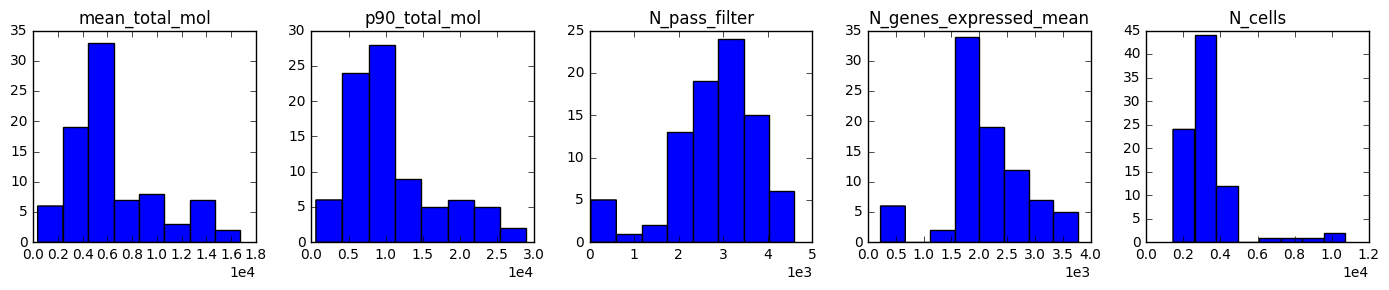

In [18]:
figure(figsize=(14,3))
for i,c in enumerate(sum_table.columns):
    subplot(151+i)
    hist(sum_table.ix[:,c], bins=8)
    gca().ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
    title(c)
tight_layout()

In [27]:
sum_table.ix[:,"N_cells"].sum()

287838.0

# Filter out samples with bad statistics

In [28]:
sum_table_filter = sum_table.copy()
sum_table_filter.mean_total_mol = sum_table_filter.mean_total_mol > 2000
sum_table_filter.p90_total_mol = sum_table_filter.p90_total_mol > 4000
sum_table_filter.N_pass_filter = sum_table_filter.N_pass_filter > 1000
sum_table_filter.N_genes_expressed_mean = sum_table_filter.N_genes_expressed_mean > 1500
sum_table_filter.N_cells = sum_table_filter.N_cells < 6000
display(sum_table_filter)

,mean_total_mol,p90_total_mol,N_pass_filter,N_genes_expressed_mean,N_cells
10X23_3,True,True,True,True,True
10X23_4,True,True,True,True,True
10X27_2,True,True,True,True,True
10X27_3,True,True,True,True,True
10X27_7,True,True,True,True,True
10X29_2,True,True,True,True,True
10X29_3,True,True,True,True,True
10X08_1,True,True,True,True,True
10X30_4,True,True,True,True,True
10X30_5,True,True,True,True,True


In [29]:
failed = sum_table_filter.index[ sum_table_filter.sum(1) <= 2 ].values
failed_files = [i for i in paths_to_check if np.any([j in i for j in failed])]

In [30]:
print('\n'.join(failed_files))

/data2/loom_files/development/10X09_1.loom
/data2/loom_files/development/10X09_2.loom
/data2/loom_files/development/10X09_3.loom
/data2/loom_files/development/10X10_4.loom
/data2/loom_files/development/10X13_2.loom
/data2/loom_files/development/10X13_3.loom


# Save to Excel file

In [61]:
import openpyxl
wb = openpyxl.Workbook()
ws = wb.active
ws.title = "Sheet1"
ws.cell(row=1, column=1, value="SampleID")
ws.cell(row=1, column=2, value="Pool")
ws.cell(row=1, column=3, value="QC")

paths_to_check_ordered = np.sort(paths_to_check)
for i,p in enumerate(paths_to_check_ordered):
    s_name = p.split("/")[-1].rstrip(".loom")
    ws.cell(row=i+2, column=1, value=s_name)
    ws.cell(row=i+2, column=3, value="FAILED" if s_name in failed else "OK")
wb.save('/data2/loom_files/development/Pooling_specification_dev.xlsx')

# Move the failed samples to a folder

In [22]:
%mkdir /data2/loom_files/development/failed

mkdir: cannot create directory '/data2/loom_files/development/failed': File exists


In [23]:
for original_path in failed_files:
    shutil.move(original_path, "/data2/loom_files/development/failed")

In [24]:
ls /data2/loom_files/development/failed

10X09_1.loom  10X09_3.loom  10X13_2.loom
10X09_2.loom  10X10_4.loom  10X13_3.loom


In [25]:
ls /data2/loom_files/development | wc -l

82
